In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!cd drive/MyDrive/

In [ ]:
#!mkdir gan_syn_data

In [ ]:
!ls

drive  sample_data


In [ ]:
!cd drive/MyDrive/gan_syn_data/

In [ ]:
!ls

drive  sample_data


In [ ]:
import torch

In [ ]:
color=['red','green']
bar=['horizontal','vertical']

In [ ]:
#generate a bunch of d*d*d images with all combinations of color and bar

In [ ]:
!mkdir drive/MyDrive/gan_syn_data/

mkdir: cannot create directory ‘drive/MyDrive/gan_syn_data/’: File exists


In [ ]:
!mkdir drive/MyDrive/gan_syn_data/data

In [ ]:
ROOT_PATH="drive/MyDrive/gan_syn_data/"

In [ ]:
from PIL import Image, ImageDraw
import random


ROOT_PATH="drive/MyDrive/gan_syn_data/data/"

d=64
IMG_WIDTH, IMG_HEIGHT = d,d

num_samples=10000
data=[]
labels=[]
cols=[]
for i in range(num_samples):
  img = Image.new('RGB', (IMG_WIDTH, IMG_HEIGHT), (3, d, d))
  draw = ImageDraw.Draw(img)
  #red
  col_choice=random.choice([0,1])
  bar_choice=random.choice([0,1])
  if col_choice==1:
    colors = [(0,0,0), (255,0,0), (0,0,0)]
    cols.append(1)
  else:
    #green
    colors = [(0,0,0), (0,255,0), (0,0,0)]
    cols.append(0)
  #random.shuffle(colors)

  length = len(colors)
  amount = IMG_WIDTH / length
  offset = amount / 2  # 1/2 line width
  x1, y1 = offset, 0
  x2, y2 = offset, IMG_HEIGHT

  for color in colors:
      endpoints = (x1, y1), (x2, y2)
      draw.line(endpoints, fill=color, width=int(amount))
      x1 += amount
      x2 += amount
  if bar_choice==1:
    img = img.rotate(90)#for horizontal
    labels.append(1)
  else:
    labels.append(0)
  img.save(ROOT_PATH + str(i)+"_"+"_label_"+str(bar_choice)+"_color_"+str(col_choice)+".jpg")

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
ROOT_PATH

NameError: ignored

In [ ]:
# Root directory for dataset
dataroot = "drive/MyDrive/gan_syn_data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
!rm -rf drive/MyDrive/gan_syn_data/.ipynb_checkpoints

In [ ]:
!mkdir drive/MyDrive/gan_syn_data/data

mkdir: cannot create directory ‘drive/MyDrive/gan_syn_data/data’: File exists


In [ ]:
!mv drive/MyDrive/gan_syn_data/*.jpg drive/MyDrive/gan_syn_data/data/

In [ ]:
!rm -rf drive/MyDrive/gan_syn_data/data/.ipynb_checkpoints

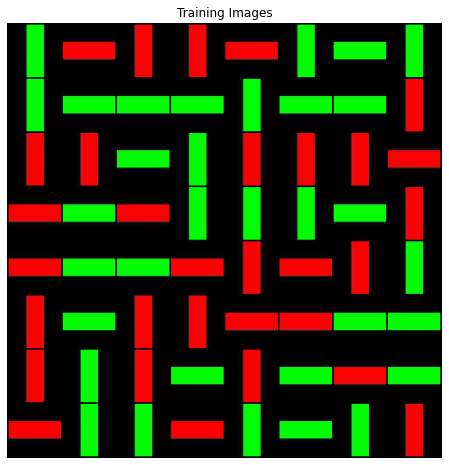

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [ ]:
# Initialize BCELoss function
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/100][0/66]	Loss_D: -0.6574	Loss_G: 0.0176	D(x): 1.8677	D(G(z)): -0.0176 /
[0/100][50/66]	Loss_D: -1.7258	Loss_G: -0.7816	D(x): 2.8132	D(G(z)): 0.7816 /


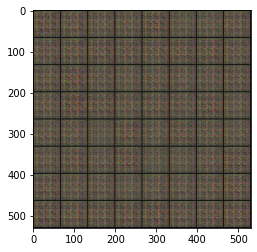

[1/100][0/66]	Loss_D: -2.5746	Loss_G: -0.2751	D(x): 3.2748	D(G(z)): 0.2751 /
[1/100][50/66]	Loss_D: -6.2348	Loss_G: 1.6055	D(x): 5.3054	D(G(z)): -1.6055 /


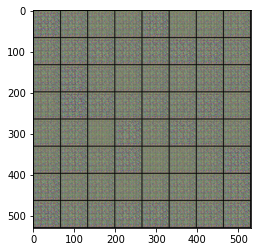

[2/100][0/66]	Loss_D: -6.6502	Loss_G: 1.9453	D(x): 5.3234	D(G(z)): -1.9453 /
[2/100][50/66]	Loss_D: -11.6161	Loss_G: 4.8487	D(x): 7.3650	D(G(z)): -4.8487 /


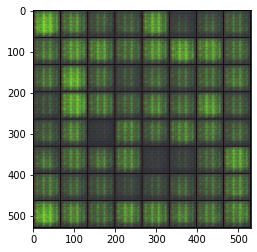

[3/100][0/66]	Loss_D: -10.8462	Loss_G: 5.4412	D(x): 7.1708	D(G(z)): -5.4412 /
[3/100][50/66]	Loss_D: -17.9183	Loss_G: 8.3026	D(x): 9.8568	D(G(z)): -8.3026 /


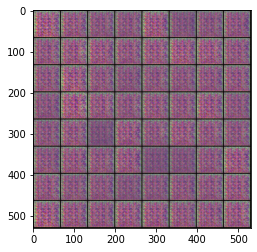

[4/100][0/66]	Loss_D: -18.6141	Loss_G: 8.8053	D(x): 10.4028	D(G(z)): -8.8053 /
[4/100][50/66]	Loss_D: -22.7302	Loss_G: 11.2077	D(x): 11.8197	D(G(z)): -11.2077 /


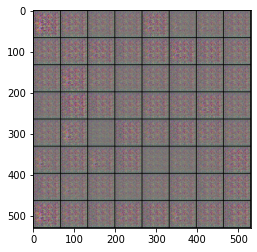

[5/100][0/66]	Loss_D: -24.0997	Loss_G: 11.9466	D(x): 12.4102	D(G(z)): -11.9466 /
[5/100][50/66]	Loss_D: -27.1461	Loss_G: 14.0093	D(x): 13.3166	D(G(z)): -14.0093 /


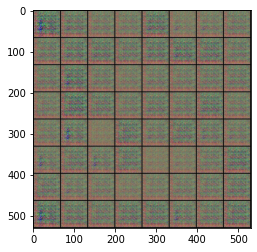

[6/100][0/66]	Loss_D: -28.1150	Loss_G: 14.5130	D(x): 13.8107	D(G(z)): -14.5130 /
[6/100][50/66]	Loss_D: -30.7757	Loss_G: 16.2776	D(x): 14.5670	D(G(z)): -16.2776 /


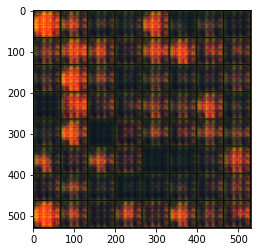

[7/100][0/66]	Loss_D: -31.1686	Loss_G: 16.4101	D(x): 14.8810	D(G(z)): -16.4101 /
[7/100][50/66]	Loss_D: -28.2870	Loss_G: 15.5440	D(x): 12.5500	D(G(z)): -15.5440 /


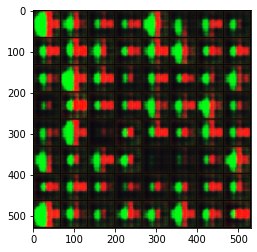

[8/100][0/66]	Loss_D: -21.1609	Loss_G: 9.3807	D(x): 7.2164	D(G(z)): -9.3807 /
[8/100][50/66]	Loss_D: -17.8148	Loss_G: 10.5726	D(x): 7.3555	D(G(z)): -10.5726 /


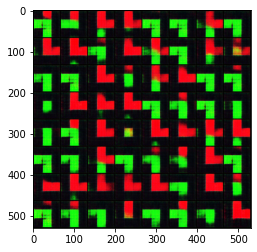

[9/100][0/66]	Loss_D: -17.0910	Loss_G: 12.6125	D(x): 10.9684	D(G(z)): -12.6125 /
[9/100][50/66]	Loss_D: -29.8557	Loss_G: 16.0362	D(x): 15.0614	D(G(z)): -16.0362 /


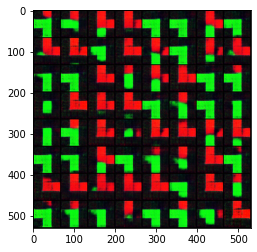

[10/100][0/66]	Loss_D: -31.6114	Loss_G: 16.3524	D(x): 15.2769	D(G(z)): -16.3524 /
[10/100][50/66]	Loss_D: -29.4641	Loss_G: 16.2983	D(x): 13.7948	D(G(z)): -16.2983 /


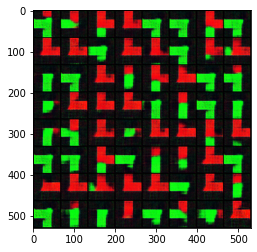

[11/100][0/66]	Loss_D: -30.9821	Loss_G: 15.6411	D(x): 15.0267	D(G(z)): -15.6411 /
[11/100][50/66]	Loss_D: -32.8451	Loss_G: 16.7175	D(x): 16.1406	D(G(z)): -16.7175 /


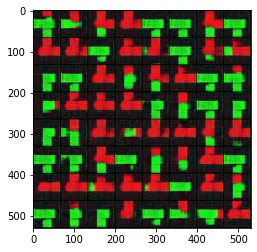

[12/100][0/66]	Loss_D: -33.0531	Loss_G: 16.6650	D(x): 16.5551	D(G(z)): -16.6650 /
[12/100][50/66]	Loss_D: -34.4352	Loss_G: 17.2464	D(x): 17.1103	D(G(z)): -17.2464 /


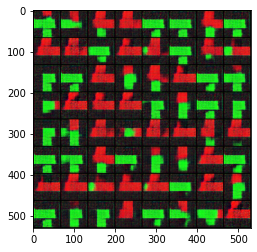

[13/100][0/66]	Loss_D: -34.1877	Loss_G: 17.3581	D(x): 17.0295	D(G(z)): -17.3581 /
[13/100][50/66]	Loss_D: -34.4249	Loss_G: 17.4276	D(x): 17.1748	D(G(z)): -17.4276 /


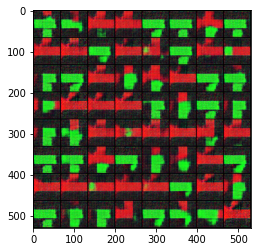

[14/100][0/66]	Loss_D: -35.0133	Loss_G: 17.6175	D(x): 17.4097	D(G(z)): -17.6175 /
[14/100][50/66]	Loss_D: -35.1979	Loss_G: 17.7896	D(x): 17.3849	D(G(z)): -17.7896 /


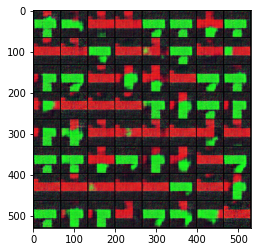

[15/100][0/66]	Loss_D: -35.6973	Loss_G: 18.0644	D(x): 17.6169	D(G(z)): -18.0644 /


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(50):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #fake
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # Calculate loss on all-real batch
        errD_real= torch.mean(netD(fake.detach()).view(-1)) - torch.mean(output) 
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        # Update D
        optimizerD.step()

        #clamp D
        
        for p in netD.parameters():
          p.data.clamp_(-0.05, 0.05)
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        #label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #-torch.mean(discriminator(critics_fake_imgs))
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = -torch.mean(netD(fake))
        # Calculate gradients for G
        errG.backward()
        D_G_z1 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f /'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD_real.item(), errG.item(), D_x, D_G_z1))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD_real.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (True or iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
    img_list=vutils.make_grid(fake, padding=2, normalize=True)
    plt.imshow(np.transpose(img_list,(1,2,0)))
    plt.show()

    iters += 1

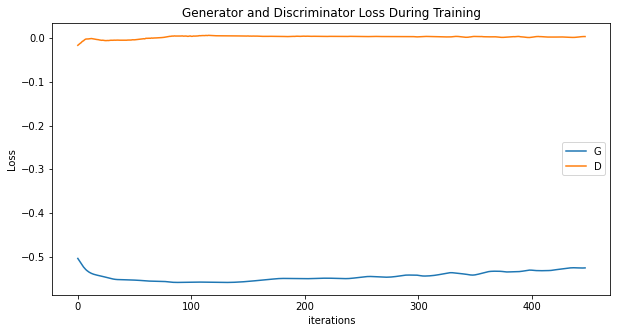

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

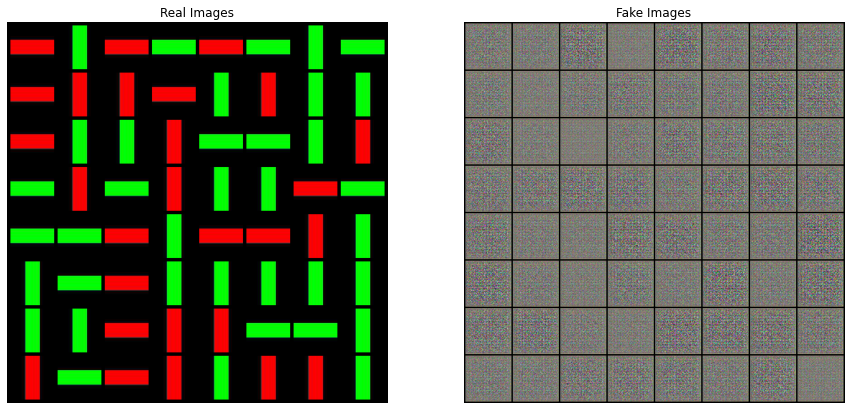

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()